In [2]:
from utils import ParquetLoader, GPSSimplifier, GPSConverter

GPSConverter("b.gpx")
ParquetLoader().save(GPSSimplifier(30).simplify(ParquetLoader().load("b.parquet")), "b_simplified.parquet")

Converti b.gpx -> b.parquet
b.parquet chargé avec 2333 lignes.
b_simplified.parquet sauvegardé avec 210 lignes.


In [7]:
from utils import TraceMap

mape = TraceMap(10)
mape.add_trace(ParquetLoader().load("a_simplified.parquet"))

a_simplified.parquet chargé avec 187 lignes.


[NoMatch] 'a_simplified.parquet' — city1 dist 16.07 km (within=False), city2 dist 2.85 km (within=True), order_ok=True
[Match] 'b_simplified.parquet' ✓  (route 87.1 km, rayon 8.71 km)
[{'file': 'b_simplified.parquet', 'route_km': 87.14851328022141, 'radius_km': 8.71485132802214, 'city1': {'coords': (48.6726066, 2.6954544), 'idx': 105, 'dist_km': 1.7411182979058804}, 'city2': {'coords': (48.8534951, 2.3483915), 'idx': 209, 'dist_km': 2.8506806722274853}}]


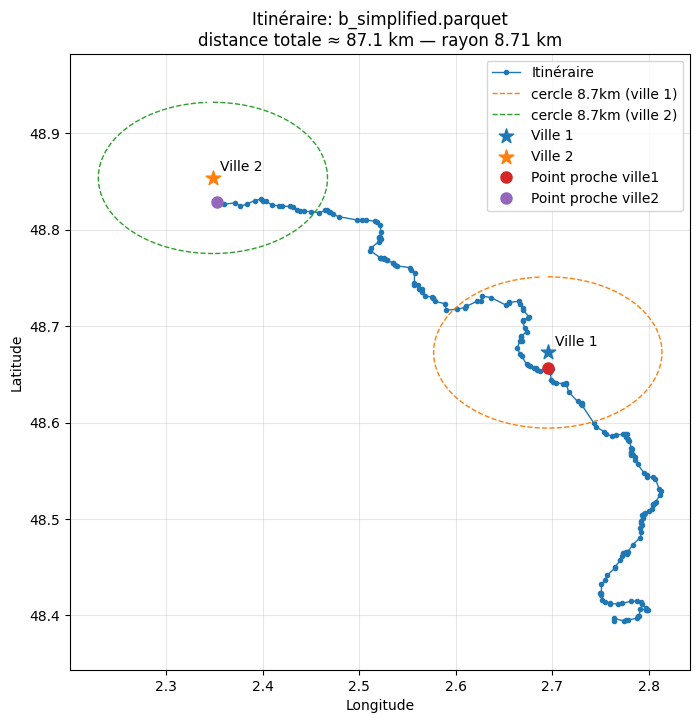

In [15]:
import time
from typing import List, Tuple, Optional, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy import distance as geopy_distance
from geopy.point import Point


class Find_with_zone:
    """
    Trouve les fichiers d'itinéraires (parquet contenant 'latitude'/'longitude')
    qui passent près de deux villes données, plus la distances du parcours est grande plus ça recherche loin.

    Principales améliorations :
    - géocodage robuste avec cache,
    - recherche du point le plus proche sur la trace pour chaque ville,
    - vérification de l'ordre (ville1 avant ville2),
    - plot amélioré (itinéraire, villes, cercles géodésiques).

    TODO
    - si la distance entre les deux point sur la carte est trop faible ducoup il parcours moins de 30km ensemble alors  c ciao
    """

    def __init__(
        self,
        files: List[str],
        cercle_ratio: float = 0.1,
        num_points_circle: int = 120,
        geolocator: Optional[Nominatim] = None,
        geocode_delay: float = 1.0,
    ):
        self.files = files
        self.cercle_ratio = cercle_ratio
        self.num_points_circle = num_points_circle
        self.geocode_delay = geocode_delay
        self.geolocator = geolocator or Nominatim(user_agent="route_finder")
        self._geocode_cache = {}  # cache pour éviter de re-géocoder
        self.available_files = []

    # --- Géocodage / utilitaires ---
    def _geocode(self, city: Union[str, Tuple[float, float]]) -> Optional[Tuple[float, float]]:
        """
        city peut être :
          - un nom de ville (str) -> on utilise Nominatim
          - un tuple (lat, lon) -> renvoyé tel quel
        Retourne (lat, lon) ou None si introuvable.
        """
        if isinstance(city, tuple) and len(city) == 2:
            return city

        if city in self._geocode_cache:
            return self._geocode_cache[city]

        try:
            loc = self.geolocator.geocode(city, exactly_one=True, timeout=10)
            time.sleep(self.geocode_delay)  # respecter rate-limit
            if loc:
                coords = (loc.latitude, loc.longitude)
                self._geocode_cache[city] = coords
                return coords
            else:
                print(f"[Géocodage] Ville '{city}' non trouvée.")
                self._geocode_cache[city] = None
                return None
        except Exception as e:
            print(f"[Géocodage] Erreur pour '{city}': {e}")
            return None

    @staticmethod
    def _km_between(a: Tuple[float, float], b: Tuple[float, float]) -> float:
        return geopy_distance.distance(a, b).km

    @staticmethod
    def route_length_km(df: pd.DataFrame) -> float:
        """Distance totale approximative de l'itinéraire (somme des segments)."""
        coords = list(zip(df['latitude'], df['longitude']))
        if len(coords) < 2:
            return 0.0
        total = 0.0
        for i in range(len(coords) - 1):
            total += geopy_distance.distance(coords[i], coords[i + 1]).km
        return total

    @staticmethod
    def find_nearest_point_index(df: pd.DataFrame, point: Tuple[float, float]) -> Tuple[int, float]:
        """
        Trouve l'indice du point dans df le plus proche de 'point'.
        Retourne (indice, distance_km).
        """
        best_idx = -1
        best_dist = float('inf')
        for i, row in df[['latitude', 'longitude']].iterrows():
            d = geopy_distance.distance((row['latitude'], row['longitude']), point).km
            if d < best_dist:
                best_dist = d
                best_idx = i
        return best_idx, best_dist

    def generate_circle(self, center: Tuple[float, float], radius_km: float) -> pd.DataFrame:
        """
        Retourne un DataFrame de coordonnées formant un cercle géodésique autour de center.
        """
        lat0, lon0 = center
        points = []
        for bearing in np.linspace(0, 360, self.num_points_circle, endpoint=False):
            dest = geopy_distance.distance(kilometers=radius_km).destination(Point(lat0, lon0), bearing)
            points.append((dest.latitude, dest.longitude))
        return pd.DataFrame(points, columns=['latitude', 'longitude'])

    # --- Process / filtrage ---
    def process(self, city1: Union[str, Tuple[float, float]], city2: Union[str, Tuple[float, float]],
                require_order: bool = True, min_radius_km: float = 1.0):
        """
        Cherche dans self.files les fichiers qui passent près de city1 et city2.
        - city1 / city2 peuvent être noms ou tuples (lat, lon).
        - require_order: si True, exige que l'index du point proche de city1 soit < index du point proche de city2.
        - min_radius_km: rayon minimal (en km) si cercle_ratio*distance trop petit.
        Résultat dans self.available_files comme une liste de dicts :
          {'file': path, 'idx_city1': int, 'dist_city1_km': float, 'idx_city2': int, 'dist_city2_km': float, 'route_km': float}
        """
        self.available_files = []
        city1_coords = self._geocode(city1)
        city2_coords = self._geocode(city2)

        if city1_coords is None or city2_coords is None:
            print("[Process] Géocodage échoué pour l'une des villes — arrêt.")
            return

        for file in self.files:
            try:
                df = pd.read_parquet(file)
            except Exception as e:
                print(f"[Process] Impossible de lire '{file}': {e}")
                continue

            if 'latitude' not in df.columns or 'longitude' not in df.columns:
                print(f"[Process] '{file}' ne contient pas 'latitude'/'longitude'.")
                continue

            route_km = self.route_length_km(df)
            radius_km = max(self.cercle_ratio * route_km, min_radius_km)

            idx1, d1 = self.find_nearest_point_index(df, city1_coords)
            idx2, d2 = self.find_nearest_point_index(df, city2_coords)

            # Condition : points proches des villes
            within1 = d1 <= radius_km
            within2 = d2 <= radius_km

            # Condition d'ordre
            order_ok = (idx1 < idx2) if require_order else True

            if within1 and within2 and order_ok:
                self.available_files.append({
                    'file': file,
                    'route_km': route_km,
                    'radius_km': radius_km,
                    'city1': {'coords': city1_coords, 'idx': idx1, 'dist_km': d1},
                    'city2': {'coords': city2_coords, 'idx': idx2, 'dist_km': d2},
                })
                print(f"[Match] '{file}' ✓  (route {route_km:.1f} km, rayon {radius_km:.2f} km)")
            else:
                print(
                    f"[NoMatch] '{file}' — city1 dist {d1:.2f} km (within={within1}), "
                    f"city2 dist {d2:.2f} km (within={within2}), order_ok={order_ok}"
                )

        if not self.available_files:
            print("[Process] Aucun fichier compatible trouvé.")

    # --- Plot ---
    def plot(self, show_all_matches: bool = True, figsize: Tuple[int, int] = (8, 8), savepath: Optional[str] = None):
        """
        Affiche les routes trouvées (self.available_files). Si show_all_matches=True, trace chaque fichier trouvé.
        Ajoute les villes, les cercles et les points les plus proches.
        """
        if not self.available_files:
            print("[Plot] Aucun résultat à afficher. Lancez d'abord process(...).")
            return

        for item in self.available_files:
            file = item['file']
            df = pd.read_parquet(file)

            plt.figure(figsize=figsize)
            plt.plot(df['longitude'], df['latitude'], '-o', markersize=3, linewidth=1, label='Itinéraire')

            # villes et cercles
            c1 = item['city1']['coords']
            c2 = item['city2']['coords']
            r = item['radius_km']

            # cercles (DataFrame)
            circ1 = self.generate_circle(c1, r)
            circ2 = self.generate_circle(c2, r)
            plt.plot(circ1['longitude'], circ1['latitude'], '--', linewidth=1, label=f'cercle {r:.1f}km (ville 1)')
            plt.plot(circ2['longitude'], circ2['latitude'], '--', linewidth=1, label=f'cercle {r:.1f}km (ville 2)')

            # marquer les villes
            plt.scatter([c1[1]], [c1[0]], marker='*', s=120, label='Ville 1', zorder=5)
            plt.scatter([c2[1]], [c2[0]], marker='*', s=120, label='Ville 2', zorder=5)
            plt.annotate("Ville 1", xy=(c1[1], c1[0]), xytext=(5, 5), textcoords='offset points')
            plt.annotate("Ville 2", xy=(c2[1], c2[0]), xytext=(5, 5), textcoords='offset points')

            # marquer les points les plus proches sur la route
            idx1 = item['city1']['idx']
            idx2 = item['city2']['idx']
            p1 = (df.loc[idx1, 'latitude'], df.loc[idx1, 'longitude'])
            p2 = (df.loc[idx2, 'latitude'], df.loc[idx2, 'longitude'])
            plt.plot([p1[1]], [p1[0]], 'o', markersize=8, label='Point proche ville1')
            plt.plot([p2[1]], [p2[0]], 'o', markersize=8, label='Point proche ville2')
            plt.title(f"Itinéraire: {file}\ndistance totale ≈ {item['route_km']:.1f} km — rayon {r:.2f} km")
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.axis('equal')
            plt.legend()
            plt.grid(alpha=0.3)

            if savepath:
                plt.savefig(savepath)
                print(f"[Plot] Sauvegardé: {savepath}")

            plt.show()


rf = RouteFinder(["a_simplified.parquet", "b_simplified.parquet"])
rf.process("Coubert", "Paris", require_order=True)
# Voir résultats :
print(rf.available_files)  # détails utiles
rf.plot()  # affiche les routes trouvées avec villes + cercles


In [5]:
# maintenat on fait le truc avec la forme : voir le dessin donc essayer de faire des courbe autour
from utils import TraceMap
ParquetLoader().load("a_simplified.parquet")


mape = TraceMap(10)
mape.add_trace(ParquetLoader().load("a_simplified.parquet"))
import numpy as np

df = ParquetLoader().load("a_simplified.parquet")
x = df['longitude'].values
y = df['latitude'].values
a, b = np.polyfit(x, y, 1)
x_min, x_max = x.min() - 0.1, x.max() + 0.1
x_line = np.linspace(x_min, x_max, 100)
y_line = a * x_line + b
line_points = list(zip(y_line, x_line))
mape.create_map()

mape.add_curve(line_points, color="red", weight=3, opacity=0.8, tooltip="Moyenne direction")
mape.save()

a_simplified.parquet chargé avec 187 lignes.
a_simplified.parquet chargé avec 187 lignes.
a_simplified.parquet chargé avec 187 lignes.


In [23]:
# la courbe est a l'envers

from utils import TraceMap
import numpy as np

# Chargement des données
df = ParquetLoader().load("a_simplified.parquet")
mape = TraceMap(10)
mape.add_trace(df)

# Données de base
x = df['longitude'].values
y = df['latitude'].values

# Ligne de régression existante
a, b = np.polyfit(x, y, 1)
x_min, x_max = x.min() - 0.1, x.max() + 0.1
x_line = np.linspace(x_min, x_max, 100)
y_line = a * x_line + b
line_points = list(zip(y_line, x_line))

def create_cone_and_exponential_curves(x_line, y_line, cone_angle_deg=80, exp_start_ratio=0.75):
    """
    Crée un cône inversé d'un côté et une courbe exponentielle de l'autre
    
    Args:
        x_line, y_line: coordonnées de la ligne centrale (rouge)
        cone_angle_deg: angle du cône en degrés
        exp_start_ratio: position où commence la courbe exp (0.75 = aux 3/4)
    """
    
    # Convertir l'angle en radians et calculer la demi-ouverture
    half_cone_angle = np.radians(cone_angle_deg / 2)
    
    # Calculer la direction de la ligne rouge
    dx = x_line[-1] - x_line[0]
    dy = y_line[-1] - y_line[0]
    line_angle = np.arctan2(dy, dx)
    line_length = np.sqrt(dx**2 + dy**2)
    
    # Vecteur perpendiculaire à la ligne rouge (normalisé)
    perp_angle = line_angle + np.pi/2
    perp_x = np.cos(perp_angle)
    perp_y = np.sin(perp_angle)
    
    # Vecteur direction de la ligne (normalisé)
    dir_x = np.cos(line_angle)
    dir_y = np.sin(line_angle)
    
    # Conversion approximative : 1 degré ≈ 111 km, donc 5km ≈ 0.045 degrés
    km_5_in_degrees = 5.0 / 111.0  # 5km convertis en degrés
    
    # Points pour le cône (côté opposé à la courbe exp)
    cone_left = []
    cone_right = []
    
    cone_start_x = x_line[1]  # Fin de la ligne rouge
    cone_start_y = y_line[1]
    
    # Créer des points pour le cône qui s'élargit vers l'arrière
    cone_length = line_length * 0.8  # Longueur du cône
    num_cone_points = 50
    
    for i in range(num_cone_points):
        # Distance depuis la pointe du cône (0->1)
        t = i / (num_cone_points - 1)
        
        # Position le long de la direction inverse de la ligne rouge
        cone_x = cone_start_x - t * cone_length * dir_x
        cone_y = cone_start_y - t * cone_length * dir_y
        
        # Largeur du cône à cette position (s'élargit avec la distance)
        cone_width = t * np.tan(half_cone_angle) * cone_length
        
        # Points du cône des deux côtés (côté opposé à la courbe exp)
        cone_left.append((cone_y - cone_width * perp_y, cone_x - cone_width * perp_x))
        cone_right.append((cone_y + cone_width * perp_y, cone_x + cone_width * perp_x))
    
    # Points pour la courbe exponentielle (côté opposé au cône)
    exp_left = []
    exp_right = []
    
    # Index de départ pour la courbe exp (aux 3/4)
    start_idx = int(0.8 * len(x_line))  
    second_cone_start_x = x_line[start_idx]
    second_cone_start_y = y_line[start_idx]
    
    # Extension de la courbe exp : 2 fois plus loin que la ligne rouge
    extension_length = line_length * 2
    total_exp_points = len(x_line) + 50  # Points supplémentaires pour l'extension
    
    for i in range(total_exp_points):
        if i < len(x_line):
            # Points sur la ligne rouge existante
            x_pt, y_pt = x_line[i], y_line[i]
        else:
            # Points d'extension au-delà de la ligne rouge
            extra_i = i - len(x_line)
            extension_t = extra_i / 50  # 0->1 pour l'extension
            
            # Continuer dans la direction de la ligne rouge
            x_pt = x_line[-1] + extension_t * extension_length * dir_x
            y_pt = y_line[-1] + extension_t * extension_length * dir_y
        
        if i < start_idx:
            # Avant le point de départ : largeur nulle
            exp_width = 0
        else:
            # Après le point de départ : commence à 5km et croît exponentiellement (plus vite)
            if i < len(x_line):
                t_exp = (i - start_idx) / (len(x_line) - start_idx)  # 0->1 sur la ligne rouge
            else:
                # Extension : continue à croître
                base_t = 1.0  # On était à 1 à la fin de la ligne rouge
                extra_t = (i - len(x_line)) / 50  # Progression dans l'extension
                t_exp = base_t + extra_t  # Continue à croître
            
            # Commence directement à 5km puis croît exponentiellement (plus vite)
            initial_width = km_5_in_degrees  # 5km de base
            # Croissance plus rapide avec exp(3 * t_exp)
            growth_factor = 1 + 1.5 * (np.exp(3.5 * t_exp) - 1) / (np.exp(3) - 1)
            exp_width = initial_width * growth_factor
        
        # Points de la courbe exp (côté opposé au cône)
        exp_left.append((y_pt + exp_width * perp_y, x_pt + exp_width * perp_x))
        exp_right.append((y_pt - exp_width * perp_y, x_pt - exp_width * perp_x))
    
    return cone_left, cone_right, exp_left, exp_right

# Créer les courbes
cone_left, cone_right, exp_left, exp_right = create_cone_and_exponential_curves(
    x_line, y_line, cone_angle_deg=80, exp_start_ratio=0.75
)

# Création de la carte
mape.create_map()

# Ajouter la ligne de régression (axe rouge)
mape.add_curve(line_points, color="red", weight=3, opacity=0.8, tooltip="Axe central")

# Ajouter les courbes du cône
mape.add_curve(cone_left, color="black", weight=2, opacity=0.7, tooltip="Cône gauche (80°)")
mape.add_curve(cone_right, color="black", weight=2, opacity=0.7, tooltip="Cône droite (80°)")

# Ajouter les courbes exponentielles (côté opposé)
mape.add_curve(exp_left, color="blue", weight=2, opacity=0.7, tooltip="Courbe exp gauche")
mape.add_curve(exp_right, color="blue", weight=2, opacity=0.7, tooltip="Courbe exp droite")

# Option: ajouter des lignes de fermeture pour mieux voir les formes
# Ligne de fermeture du cône (au bout)
cone_closure = [cone_left[-1], cone_right[-1]]
mape.add_curve(cone_closure, color="black", weight=1, opacity=0.5, tooltip="Fermeture cône")

# Ligne de fermeture de la zone exp (au bout)
exp_closure = [exp_left[-1], exp_right[-1]]
mape.add_curve(exp_closure, color="blue", weight=1, opacity=0.5, tooltip="Fermeture exp")

# Sauvegarder la carte
mape.save()

print("Carte créée avec :")
print("- Cône (noir) partant de la FIN de la ligne rouge, s'élargissant vers l'arrière")
print("- Courbe exponentielle (bleue) continue 2x plus loin que la ligne rouge")
print("- Croissance exponentielle plus rapide (facteur 1.5 et exp(3*t))")
print("- Le cône et la courbe exp sont sur des côtés opposés de l'axe rouge")

a_simplified.parquet chargé avec 187 lignes.
Carte créée avec :
- Cône (noir) partant de la FIN de la ligne rouge, s'élargissant vers l'arrière
- Courbe exponentielle (bleue) continue 2x plus loin que la ligne rouge
- Croissance exponentielle plus rapide (facteur 1.5 et exp(3*t))
- Le cône et la courbe exp sont sur des côtés opposés de l'axe rouge


In [ ]:
# la courbe est a l'envers

from utils import TraceMap
import numpy as np

# Chargement des données
df = ParquetLoader().load("a_simplified.parquet")
mape = TraceMap(10)
mape.add_trace(df)

# Données de base
x = df['longitude'].values
y = df['latitude'].values

# Régression linéaire
a, b = np.polyfit(x, y, 1)

# Projection du point (x0, y0) sur la droite y = ax + b
def project_point(xp, yp, a, b):
    # Equation perpendiculaire : y = (-1/a)x + c
    if a == 0:  # droite horizontale
        return xp, b
    x_proj = (xp + a * yp - a * b) / (a**2 + 1)
    y_proj = a * x_proj + b
    return x_proj, y_proj

# Projeter début et fin du GPX
x_start_proj, y_start_proj = project_point(x[0], y[0], a, b)
x_end_proj, y_end_proj     = project_point(x[-1], y[-1], a, b)

# Générer la droite rouge entre ces deux projections
x_line = np.linspace(x_start_proj, x_end_proj, 100)
y_line = a * x_line + b
line_points = list(zip(y_line, x_line))

def create_two_cones(x_line, y_line, cone_angle_deg=80, second_cone_offset=0.3):
    """
    Crée deux cônes : un partant de la fin, un autre un peu en retrait
    
    Args:
        x_line, y_line: coordonnées de la ligne centrale (rouge)
        cone_angle_deg: angle du cône en degrés
        second_cone_offset: position de départ du second cône (0.3 = aux 30% de la ligne)
    """
    
    # Convertir l'angle en radians et calculer la demi-ouverture
    half_cone_angle = np.radians(cone_angle_deg / 2)
    
    # Calculer la direction de la ligne rouge
    dx = x_line[-1] - x_line[0]
    dy = y_line[-1] - y_line[0]
    line_angle = np.arctan2(dy, dx)
    line_length = np.sqrt(dx**2 + dy**2)
    
    # Vecteur perpendiculaire à la ligne rouge (normalisé)
    perp_angle = line_angle + np.pi/2
    perp_x = np.cos(perp_angle)
    perp_y = np.sin(perp_angle)
    
    # Vecteur direction de la ligne (normalisé)
    dir_x = np.cos(line_angle)
    dir_y = np.sin(line_angle)
    
    # PREMIER CÔNE (comme avant, partant de la fin)
    first_cone_curve = []
    start_idx = int(0.5 * len(x_line))  
    
    cone_start_x = x_line[start_idx]  # Fin de la ligne rouge
    cone_start_y = y_line[start_idx]
    
    cone_length = line_length * 4  # Longueur du cône
    num_cone_points = 50
    
    # Côté gauche du premier cône (aller)
    for i in range(num_cone_points):
        t = i / (num_cone_points - 1)
        cone_x = cone_start_x - t * cone_length * dir_x
        cone_y = cone_start_y - t * cone_length * dir_y
        cone_width = t * np.tan(half_cone_angle) * cone_length
        first_cone_curve.append((cone_y - cone_width * perp_y, cone_x - cone_width * perp_x))
    
    # Côté droit du premier cône (retour)
    for i in reversed(range(num_cone_points)):
        t = i / (num_cone_points - 1)
        cone_x = cone_start_x - t * cone_length * dir_x
        cone_y = cone_start_y - t * cone_length * dir_y
        cone_width = t * np.tan(half_cone_angle) * cone_length
        first_cone_curve.append((cone_y + cone_width * perp_y, cone_x + cone_width * perp_x))
    
    # SECOND CÔNE (en retrait, de l'autre côté)
    second_cone_curve = []
    
    # Point de départ du second cône (en retrait sur la ligne rouge)
    second_cone_start_x = x_line[-1]
    second_cone_start_y = y_line[-1]
    
    # Le second cône va dans la direction OPPOSÉE (vers l'avant)
    second_cone_length = line_length * 4  # Un peu plus court
    
    # Côté gauche du second cône (aller)
    for i in range(num_cone_points):
        t = i / (num_cone_points - 1)
        cone_x = second_cone_start_x + t * second_cone_length * dir_x
        cone_y = second_cone_start_y + t * second_cone_length * dir_y
        cone_width = t * np.tan(half_cone_angle) * second_cone_length
        second_cone_curve.append((cone_y + cone_width * perp_y, cone_x + cone_width * perp_x))
    
    # Côté droit du second cône (retour)
    for i in reversed(range(num_cone_points)):
        t = i / (num_cone_points - 1)
        cone_x = second_cone_start_x + t * second_cone_length * dir_x
        cone_y = second_cone_start_y + t * second_cone_length * dir_y
        cone_width = t * np.tan(half_cone_angle) * second_cone_length
        second_cone_curve.append((cone_y - cone_width * perp_y, cone_x - cone_width * perp_x))
    
    ### rect ###

    start_idx = int(0.5 * len(x_line))
    end_idx = 1

    rect_start_x = x_line[start_idx]
    rect_start_y = y_line[start_idx]
    rect_end_x   = x_line[end_idx]
    rect_end_y   = y_line[end_idx]

    rect_width = line_length * 0.2  # largeur du rectangle

    rectangle = [
        (rect_start_y - rect_width * perp_y, rect_start_x - rect_width * perp_x),  # coin bas gauche
        (rect_start_y + rect_width * perp_y, rect_start_x + rect_width * perp_x),  # coin haut gauche
        (rect_end_y   + rect_width * perp_y, rect_end_x   + rect_width * perp_x),  # coin haut droit
        (rect_end_y   - rect_width * perp_y, rect_end_x   - rect_width * perp_x),  # coin bas droit
        (rect_start_y - rect_width * perp_y, rect_start_x - rect_width * perp_x),  # retour au début
    ]

    return first_cone_curve, second_cone_curve, rectangle

# Créer les deux cônes
first_cone, second_cone, rectangle = create_two_cones(
    x_line, y_line, cone_angle_deg=80, second_cone_offset=0.3
)

# Création de la carte
mape.create_map()

# Ajouter la ligne de régression (axe rouge)
mape.add_curve(line_points, color="red", weight=3, opacity=0.8, tooltip="Axe central")

# Ajouter le premier cône (noir, partant de la fin)
mape.add_curve(first_cone, color="black", weight=2, opacity=0.7, tooltip="Premier cône (fin de ligne)")

# Ajouter le second cône (bleu, en retrait)
mape.add_curve(rectangle, color="green", weight=2, opacity=0.7, tooltip="Rectangle milieu→fin")
mape.add_curve(second_cone, color="blue", weight=2, opacity=0.7, tooltip="Second cône (en retrait)")

# Sauvegarder la carte
mape.save()

print("Carte créée avec :")
print("- Premier cône (noir) partant de la FIN de la ligne rouge, s'élargissant vers l'arrière")
print("- Second cône (bleu) partant à 30% de la ligne rouge, s'élargissant vers l'avant")
print("- Deux cônes symétriques de chaque côté de la ligne rouge")

a_simplified.parquet chargé avec 187 lignes.
Carte créée avec :
- Premier cône (noir) partant de la FIN de la ligne rouge, s'élargissant vers l'arrière
- Second cône (bleu) partant à 30% de la ligne rouge, s'élargissant vers l'avant
- Deux cônes symétriques de chaque côté de la ligne rouge
